**Inicialización**


In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk

In [ ]:
aleatorio = 42
np.random.seed(aleatorio)

**Obtención de Datos**

In [ ]:
datos = pd.read_csv("drive/MyDrive/Colab Notebooks/datos_desercion.csv")
datos.head()

,cant_semestres,sexo,prom_notas_semestre,prom_inasistencias,cursos_reprobados,desercion
0,0,F,9.332000,8.800000,3,0
1,0,F,11.606000,14.600000,1,0
2,0,M,15.052500,11.375000,0,0
3,0,M,9.261666,17.666666,4,0
4,0,M,12.985000,8.666667,2,0


**Visualización de Datos**

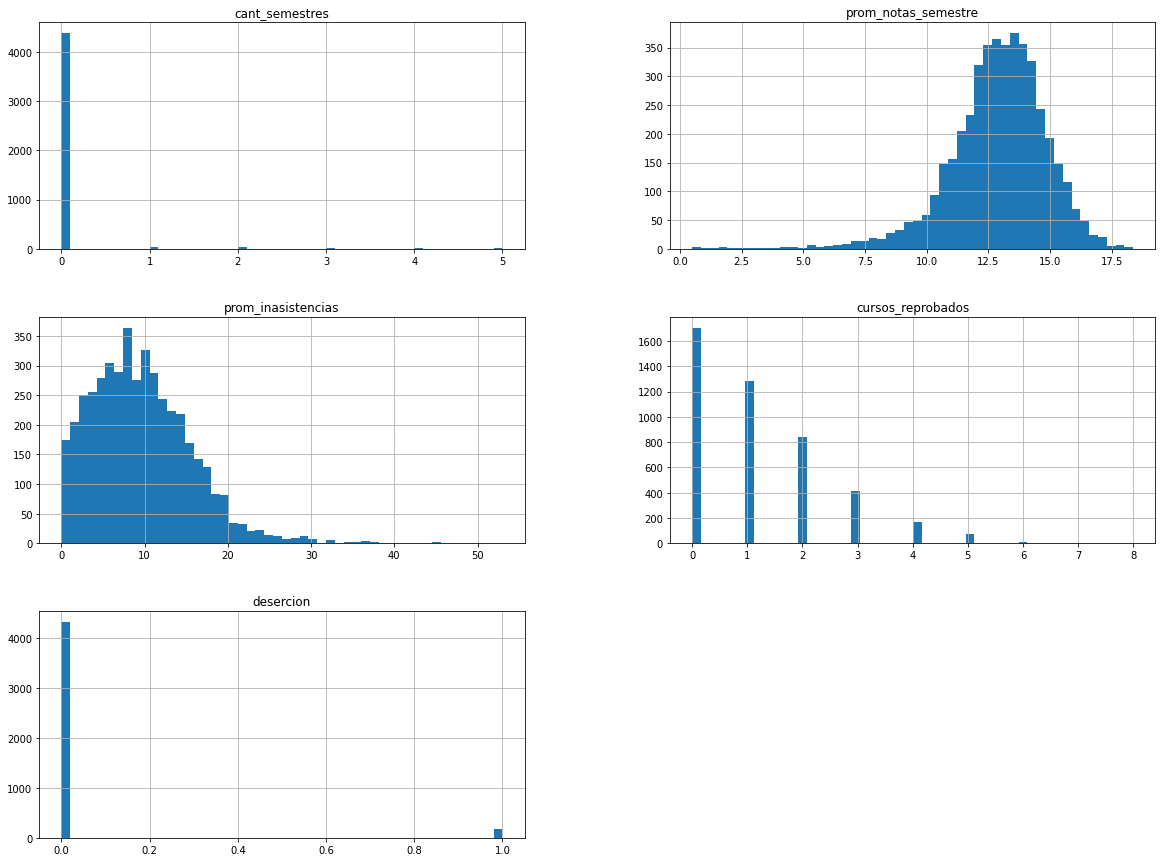

In [ ]:
import matplotlib.pyplot as plt
datos.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
corr_matrix = datos.corr()
corr_matrix["desercion"].sort_values(ascending=False)

desercion              1.000000
cant_semestres         0.718681
prom_inasistencias     0.210633
cursos_reprobados      0.110872
prom_notas_semestre   -0.246635
Name: desercion, dtype: float64

**Preprocesamiento de datos**

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(datos, test_size=0.2, random_state=aleatorio)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=aleatorio)
for train_index, test_index in split.split(datos, datos["desercion"]):
    str_train_set = datos.loc[train_index]
    str_test_set = datos.loc[test_index]

In [ ]:
def income_cat_proportions(data):
    return data["desercion"].value_counts() / len(data)

train_set, test_set = train_test_split(datos, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(datos),
    "Stratified": income_cat_proportions(str_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
0,0.96,0.96,0.954444,-0.578704,0.0
1,0.04,0.04,0.045556,13.888889,0.0


Siendo aleatorio se tiene un 14% de error (usando aleatorio 42)

Se elimina la columna sexo de las no categoricas


In [ ]:
data_num = str_train_set.drop("sexo", axis=1)
data_cat = str_train_set["sexo"]

Revisamos si existen valores incompletos

In [ ]:
sample_incomplete_rows = data_num[data_num.isnull().any(axis=1)].head()
sample_incomplete_rows

NameError: ignored

Si hubiese un orden se podria utilizar este metodo

In [ ]:
data_cat_encoded, data_categories = data_cat.factorize()
data_categories = str_train_set

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
data_1hot = encoder.fit_transform(data_cat_encoded.reshape(-1,1))
data_1hot.toarray()

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):

        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion

num_attribs = list(data_num)
cat_attribs = ["sexo"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [ ]:
data_pipe = full_pipeline.fit_transform(str_train_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int

In [ ]:
data_test = full_pipeline.fit_transform(str_test_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int

In [ ]:
data_label = str_train_set["desercion"].copy()

In [ ]:
data_label_test = str_test_set["desercion"].copy()

In [ ]:
def sigmoide(x):
  return 1/(1+np.exp(-x))

In [ ]:
def fun_cost(pre, y, m):
  return -1/m*(np.sum(y.T*np.log(pre)+(1-y).T*np.log(1-pre)))

In [ ]:
def Reg_log(X,Y,theta,ratio,rep):

  tam_x = X.shape[0]
  X = np.hstack((np.ones((tam_x,1)),X))

  costs = []

  for i in range(rep):
    theta = theta - (ratio/tam_x)* (X.T @ (sigmoide(X@theta)-Y))
    costs.append(fun_cost(sigmoide(X@theta),Y,tam_x))

  return (costs,theta)


In [ ]:
def prediccion(X,theta):
  return np.round(sigmoide(np.hstack((np.ones((X.shape[0],1)),X))@theta))

In [ ]:
theta = np.zeros((data_pipe.shape[1]+1,1))

In [ ]:
costs,theta = Reg_log(data_pipe,data_label,theta,0.05,200)

In [ ]:
theta = theta[0][0],theta[1][0],theta[2][0],theta[3][0],theta[4][0],theta[5][0],theta[6][0],theta[7][0]
theta = (np.array(theta).reshape(8,-1))

In [ ]:
from sklearn.metrics import mean_squared_error

data_predict = prediccion(data_test,theta)
log_mse = mean_squared_error(data_label_test, data_predict)
log_rmse = np.sqrt(log_mse)
log_rmse

0.2

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state = aleatorio)
log_reg.fit(data_pipe,data_label)

LogisticRegression(random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error

data_predict = log_reg.predict(data_pipe)
log_mse = mean_squared_error(data_label, data_predict)
log_rmse = np.sqrt(log_mse)
log_rmse

0.0

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_reg = DecisionTreeClassifier(random_state=aleatorio)
tree_reg.fit(data_pipe, data_label)

DecisionTreeClassifier(random_state=42)

In [ ]:
data_predict = tree_reg.predict(data_test)
tree_mse = mean_squared_error(data_label_test, data_predict)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Usar LinearSVC si se trabaja con muchos datos

In [ ]:
from sklearn.svm import SVC

SVC = SVC(random_state=aleatorio)
SVC.fit(data_pipe, data_label)

SVC(random_state=42)

In [ ]:
data_predict = SVC.predict(data_test)
SVC_mse = mean_squared_error(data_label_test, data_predict)
SVC_rmse = np.sqrt(SVC_mse)
SVC_rmse

0.0

In [ ]:
from sklearn.neural_network import MLPClassifier

M_learn = MLPClassifier(random_state=aleatorio, max_iter=300)
M_learn.fit(data_pipe, data_label)

MLPClassifier(max_iter=300, random_state=42)

In [ ]:
data_predict = M_learn.predict(data_pipe)
M_learn_mse = mean_squared_error(data_label, data_predict)
M_learn_rmse = np.sqrt(M_learn_mse)
M_learn_rmse

0.0

Inicialmente todos son iguales

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, data_pipe, data_label,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(scores)

Scores: [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
Mean: 0.0
Standard deviation: 0.0


In [ ]:
scores = cross_val_score(log_reg, data_pipe, data_label,
                         scoring="neg_mean_squared_error", cv=10)
log_rmse_scores = np.sqrt(-scores)
display_scores(scores)

Scores: [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
Mean: 0.0
Standard deviation: 0.0


In [ ]:
scores = cross_val_score(SVC, data_pipe, data_label,
                         scoring="neg_mean_squared_error", cv=10)
SVC_rmse_scores = np.sqrt(-scores)
display_scores(scores)

Scores: [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
Mean: 0.0
Standard deviation: 0.0


In [ ]:
scores = cross_val_score(M_learn, data_pipe, data_label,
                         scoring="neg_mean_squared_error", cv=10)
M_learn_rmse_scores = np.sqrt(-scores)
display_scores(scores)